In [1]:
import sys
import numpy as np
import pandas as pd
import pymongo
import bson
import json
import time
import datetime
import os
import collections
import random
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.summarization import keywords
import csv
import string
import re
import io
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import gensim.downloader as api
import networkx as nx
import math
from tqdm import trange, tqdm
from symspellpy.symspellpy import SymSpell, Verbosity
from nltk import word_tokenize
nltk.download('stopwords')
from networkx.algorithms import community
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import igraph as ig
import louvain
import leidenalg
stopwords = nltk.corpus.stopwords.words('english')
import hdbscan
import torch
from transformers import AutoTokenizer, BertTokenizer, BertModel
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

[nltk_data] Downloading package stopwords to /home/abose/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-1-5d0b38acdc55>:40: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [2]:
contractions = {
"how're": "how are",
"how's": "how is",
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [3]:
def extend_doc(doc):
    tokens = doc.split()
    for idx, token in enumerate(tokens):
        if token in contractions:
            tokens[idx]=contractions[token]
    tokens = ' '.join(tokens)
    return tokens

In [4]:
def hook_compound(input_termList):
#     if not input_termList or input_termList == None or input_termList == "":
#         return input_termList
    # maximum edit distance per dictionary precalculation
    symSpell_1st_TotalTweetText=[]
    max_edit_distance_dictionary = 2
    prefix_length = 7
    # create object
    sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)
    # load dictionary
    dictionary_path = os.path.join(os.path.dirname("E:\\Threat_Intel_Research\\"),"frequency_dictionary_en_82_765.txt")
    term_index = 0  # column of the term in the dictionary text file
    count_index = 1  # column of the term frequency in the dictionary text file
    if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
        print("Dictionary file not found")
        return

    # max edit distance per lookup (per single word, not per whole input string)
    max_edit_distance_lookup = 2
    input_term2 = re.sub(r"http\S+", "", input_termList)
    suggestions = sym_spell.lookup_compound(input_term2, max_edit_distance_lookup)
    for suggestion in suggestions:
        symSpell_1st_TotalTweetText.append(suggestion.term)
 
    return symSpell_1st_TotalTweetText

In [5]:
def mainLookUp(input_termLookList):
#     if not input_termLookList or input_termLookList == None or input_termLookList == "":
#         return input_termLookList
    symSpell_2nd_TotalTweetText=[]
    # maximum edit distance per dictionary precalculation
    max_edit_distance_dictionary = 0
    prefix_length = 7
    # create object
    sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)
    # load dictionary
    dictionary_path = os.path.join(os.path.dirname("E:\\Threat_Intel_Research\\"),"frequency_dictionary_en_82_765.txt")
    term_index = 0  # column of the term in the dictionary text file
    count_index = 1  # column of the term frequency in the dictionary text file
    if not sym_spell.load_dictionary(dictionary_path, term_index, count_index):
        print("Dictionary file not found")
        return

    # a sentence without any spaces
    if input_termLookList:
        result = sym_spell.word_segmentation(input_termLookList)
        symSpell_2nd_TotalTweetText.append(result.corrected_string)
    return symSpell_2nd_TotalTweetText

In [6]:
def clean_doc(doc):
    # split into tokens by white space
    #doc = re.sub(r\"http\\S+\", \"\", doc)
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    #remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords)
    tokens = [w for w in tokens if not w in stop_words]
    #tokens = [stemmer.stem(t) for t in tokens]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [7]:
def process_text(text):
    text = extend_doc(text)
#     textSpell = hook_compound(text)
#     if len(textSpell[0])>=5:
#         textSpell = mainLookUp(textSpell[0])
#         cleanedText = clean_doc(textSpell[0])
    if len(text)>=5:
        cleanedText = clean_doc(text)
    else:
        cleanedText="NAAAN"
    return cleanedText

In [8]:
#define vectorizer parameters
def apply_TFIDF(fname):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.99,lowercase=True, max_features=200000,min_df=0.001, stop_words='english', use_idf=True)
    #check_mat=tfidf_vectorizer.fit(fname)
    #print("check ", check_mat.vocabulary_)
    tfidf_matrix = tfidf_vectorizer.fit_transform(fname) #fit the vectorizer to synopses
    #print(tfidf_matrix.shape, tfidf_matrix[0,0], tfidf_matrix[0,1], tfidf_matrix[0,2], tfidf_matrix[0,3])
    terms = tfidf_vectorizer.get_feature_names()
    #print(tfidf_matrix.shape, " + ",terms, tfidf_vectorizer.idf_)
    print(" + ", tfidf_matrix.shape, " + ")
    return tfidf_matrix

In [9]:
def userObjectDictionaryFunction():
    connection=pymongo.MongoClient()
    srcUserDB=connection.user_src_identification
    collection=srcUserDB.taggedData40k
    cursor=collection.find({},{"_id":0}).limit(39999)
    userObjectData=[]
    userIdDict=dict()
    for data in cursor:
        userDataDict=dict()
        for key, value in data.items():
            if key=="id":
                userID=value
            if key=="Description":
                userDataDict.update({"Description":value})
            if key=="DescTag":
                userDataDict.update({"DescTag":value})
            if key=="Followers":
                userDataDict.update({"Followers":value})
            if key=="Following":
                userDataDict.update({"Following":value})
            if key=="Tweets":
                userDataDict.update({"Tweets":value})
            if key=="TweetsTags":
                userDataDict.update({"TweetsTags":value})
            if key=="AllText":
                userDataDict.update({"AllText":value})
            if key=="AllTextTags":
                userDataDict.update({"AllTextTags":value})
        userIdDict.update({int(userID):userDataDict})
    return userIdDict
userIdDict = userObjectDictionaryFunction()

In [10]:
len(userIdDict)

39999

In [11]:
######## Only For Validation #########
from ast import literal_eval
validation_DF = pd.read_json("annotated_smallNetwork.json", lines=True)
validation_DF.head(5)

,id,Description,DescTag,Tweets,TweetsTags,AllText,AllTextTags,Followers,Following,Annotation
0,1161296115637084162,#Spider Overlord calling #darknet home. Talk #...,[/technology and computing/hardware/computer c...,[A wild sponsor appears! Two more bundles hat...,"[[/style and fashion/luxury goods, /pets/large...",A wild sponsor appears! Two more bundles hath...,"[/art and entertainment/movies and tv/movies, ...","[1112062964260110336, 985304744146202624, 1304...","[347191988, 1302055132822110209, 14727747, 330...",relevant
1,1112062964260110336,🍣 researcher 🦕 pentester 😈 web monkey 🙊 datteb...,[/technology and computing/internet technology...,[Perhaps currently I 'm going through the most...,"[[/society/unrest and war, /art and entertainm...",@alicanact60 @Hacker0x01 👍👍👍👍👍@SecGoblin @root...,"[/technology and computing/hardware, /technolo...","[1229142485823315968, 28482605, 773838475]","[1145546584752394241, 1235115096528936960, 220...",irrelevant
2,985304744146202624,bebe gay III 🏳️‍🌈 ه҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈...,[/society/gay life],[],[],bebe gay III 🏳️‍🌈 ه҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈̿҈...,[/society/gay life],[],[],irrelevant
3,861889353869557762,"Hi, it's me // SEO Class of 2008 // Autodidact...",[/technology and computing/internet technology...,[Airbnb markets are crazy right now https://t....,"[[/travel/vacation rentals, /finance/investing...",Airbnb markets are crazy right now https://t.c...,"[/food and drink/vegetarian, /food and drink/v...","[1026799219716177920, 1134088559617630208, 117...","[22589449, 2707742660, 1099713672434335744]",irrelevant
4,733074959338213379,Cybersecurity is a ILLUSION,"[/technology and computing/computer security, ...",[],[],Cybersecurity is a ILLUSION,"[/technology and computing/computer crime, /te...",[],[],relevant


Name: 
Type: DiGraph
Number of nodes: 938
Number of edges: 964
Average in degree:   1.0277
Average out degree:   1.0277


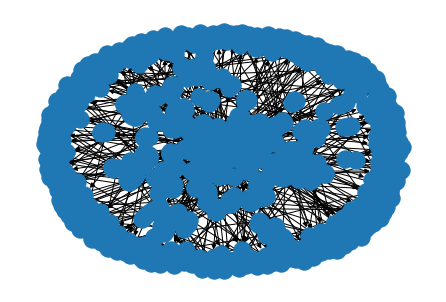

In [12]:
######## Only For Validation #########
val_FollowerNode = list()
val_FollowingNode = list()
# masterSet = set()
nodeId_Set= set(validation_DF['id'])
for index, DataRow in validation_DF.iterrows():
    if 'Followers' in DataRow:
#         for val_followerKey, val_follower in enumerate(literal_eval(DataRow['Followers'])):
        for val_followerKey, val_follower in enumerate(DataRow['Followers']):
#             masterSet.add(DataRow['id'])
#             masterSet.add(val_follower)
            if val_follower in nodeId_Set:
                val_FollowerNode.append((int(DataRow['id']), int(val_follower), 1))
    if 'Following' in DataRow:
#         for val_followingKey, val_following in enumerate(literal_eval(DataRow['Following'])):
        for val_followingKey, val_following in enumerate(DataRow['Following']):
#             masterSet.add(DataRow['id'])
#             masterSet.add(val_following)
            if val_following in nodeId_Set:
                val_FollowingNode.append((int(val_following), int(DataRow['id']), 1))
            
val_FollowerDF = pd.DataFrame(val_FollowerNode, columns =['Src', 'Des', 'Score'])
val_FollowingDF= pd.DataFrame(val_FollowingNode, columns = ['Src', 'Des', 'Score'])
val_FollowDF = pd.concat([val_FollowerDF,val_FollowingDF])
val_FollowDF.to_csv("val_FollowDF.csv", sep=',', index=False, header=False)
val_nx_graph=nx.read_edgelist('val_FollowDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
print(nx.info(val_nx_graph))
nx.draw(val_nx_graph)
plt.show()

In [13]:
######## Only For Validation #########
valid_userIdDict = {nodeID:userIdDict[nodeID] for nodeID in nodeId_Set if nodeID in userIdDict}
userIdDict = valid_userIdDict

In [14]:
print(len(userIdDict.keys()), len(nodeId_Set), userIdDict.keys())

176 938 dict_keys([1112062964260110336, 985304744146202624, 1161296115637084162, 861889353869557762, 733074959338213379, 1304859910270668801, 1274702196995694595, 1270344917483761665, 928185503488323584, 1138622123834953728, 1296940906302537730, 869595885377867782, 1256068439824756748, 1255450909540220930, 1207329318369542149, 1060694041, 92766283, 33099864, 15831150, 2962456691, 716771066346082304, 788041253405331456, 609536134, 1289965406711451649, 23543947, 709431274184773635, 4876159150, 19241206, 18473212, 865470364402327552, 1158232598285393920, 269046025, 419854605, 3277682995, 31502643, 11348282, 770781940341288960, 3687025035, 835035547, 1726433694, 23089614, 177363408, 79923701, 37771774, 42920448, 856759714868117504, 826610423025778688, 1263908877092995073, 617654802, 182493733, 37433900, 3254815295, 16810559, 14707266, 14727747, 1200437827, 517077573, 890044032369512449, 1401135751, 968756605184593922, 1227460814266912770, 59230864, 557853341, 18576042, 347191988, 426363584

In [15]:
def create_Json_Processed_Data_File():
    for userID, entries in userIdDict.items():
        processedTweetTextList = list()
        if "Tweets" in entries:
            if len(entries["Tweets"]) != 0:
                for tweetText in entries["Tweets"]:
                    if len(tweetText) <= 5:
                        continue
                    else:
                        processedTweetTextList.append(process_text(tweetText))
                entries.update({"Tweets":processedTweetTextList})
            else:
                del entries["Tweets"]
        if "AllText" in entries:
            if len(entries["AllText"]) >= 5:
                entries.update({"AllText":process_text(entries["AllText"])})
            elif "Tweets" in entries and len(entries["AllText"]) < 5 and len(entries["Tweets"]) >= 2:
                entries.update({"AllText":' '.join(processedTweetTextList)})
            else:
                del entries["AllText"]
        if "Description" in entries:
            if len(entries["Description"]) >= 5:
                entries.update({"Description":process_text(entries["Description"])})
            else:
                del entries["Description"]
        if 'DescTag' in entries:
            if len(entries['DescTag']) == 0:
                del entries['DescTag']
    with open('userIdDict.json', 'w') as fp:
        json.dump(userIdDict, fp)
create_Json_Processed_Data_File()

In [16]:
def categoryAnalyzer(tweetID, Type):
    userScoreDict=dict()
    score=0
    keepOrDiscard=True
    if tweetID not in userIdDict:
        userScoreDict[tweetID] = 0
        keepOrDiscard = False
        return keepOrDiscard, userScoreDict
    if "TweetsTags" not in userIdDict[tweetID] and "DescTag" not in userIdDict[tweetID]:
        userScoreDict[tweetID] = 0
        keepOrDiscard = False
        return keepOrDiscard, userScoreDict
    if "TweetsTags" in userIdDict[tweetID] and Type==True:
        countTech=0
        countSci=0
        for per_TextID, categoryList in enumerate(userIdDict[tweetID]["TweetsTags"]):
            for tagID, category in enumerate(categoryList):
                if "antivirus and malware" in category:
                    score=score+1
                    break
                if "technology and computing" in category:
                    if (countTech%5)==0:
                        score=score+0.5
                    countTech=countTech+1
                    break
                if "computer science" in category:
                    if (countSci%5)==0:
                        score=score+0.1
                    countSci=countSci+1
        if countTech<=2:
            userScoreDict[tweetID] = 0
            keepOrDiscard = False
    if "DescTag" in userIdDict[tweetID] and Type==True:
        for tagID, category in enumerate(userIdDict[tweetID]["DescTag"]):
            if "technology and computing" in category:
                score=score+2
                break
            if "computer science" in category:
                score=score+0.5
    if keepOrDiscard==True:
        userScoreDict[tweetID] = score
#     else:
#         print("Assign 0")
    return keepOrDiscard, userScoreDict

In [17]:
# categoryAnalyzer(1006326206579511296, True)
# userIdDict[222405719]

In [18]:
followerNode=list()
followingNode=list()
for key, item in userIdDict.items():
    if 'Followers' in item:
        for follrKey, followerVal in enumerate(item['Followers']):
            followerNode.append((int(key), int(followerVal), 1.00))
    if 'Following' in item:
        for follngKey, followingVal in enumerate(item['Following']):
            followingNode.append((int(followingVal), int(key), 1.00))

In [ ]:
followerDF = pd.DataFrame(followerNode, columns =['Src', 'Des', 'Score'])
followingDF= pd.DataFrame(followingNode, columns = ['Src', 'Des', 'Score'])
followRelnDF = pd.concat([followerDF,followingDF])
followerDF.to_csv("followerDF.csv", sep=',', index=False, header=False)
followingDF.to_csv("followingDF.csv", sep=',', index=False, header=False)
followRelnDF.to_csv("followRelnDF.csv", sep=',', index=False, header=False)

In [ ]:
def graph_reader():
    """
    Function to read the graph from the path.
    :param path: Path to the edge list.
    :return graph: NetworkX object returned.
    """
    graph=nx.read_edgelist('followRelnDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
    graph1=nx.read_edgelist('followerDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
    graph2=nx.read_edgelist('followingDF.csv', delimiter=',', data=(('weight',float),), nodetype=int, create_using=nx.DiGraph())
    return graph, graph1, graph2

In [ ]:
nx_graph, graph1, graph2 = graph_reader()
nx_graph.edges()

In [ ]:
nx_graph.nodes()
# print(nx.info(nx_graph))
# nx.draw(nx_graph)
# plt.show()

In [19]:
######## Only For Validation #########
nx_graph = val_nx_graph

## Community Detection using Girvan-Newman Algorithm 

In [ ]:
communities_generator = community.girvan_newman(nx_graph)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
sorted(map(sorted, next_level_communities))

In [ ]:
testList = sorted(map(sorted, next_level_communities))
len(testList)

In [ ]:
girvan_PartitionDict=dict()
for idx, subGrList in enumerate(testList):
    for ind, node in enumerate(subGrList):
        girvan_PartitionDict.update({node:idx})
# pos = nx.spring_layout(nx_graph)
# cmap = cm.get_cmap('viridis', max(girvan_PartitionDict.values()) + 1)
# nx.draw_networkx_nodes(nx_graph, pos, girvan_PartitionDict.keys(), node_size=40, cmap=cmap, node_color=list(girvan_PartitionDict.values()))
# nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)
# plt.show()

## Community Detection on Leiden Algorithm (Networkx+igraph)

In [ ]:
# print(ig.Graph.Erdos_Renyi(100, 0.1, directed=True))
# list(zip(*list(zip(*nx.to_edgelist(nx_graph)))[:2]))
# type(nx.to_scipy_sparse_matrix(nx_graph))
# nx_graph = nx.Graph()
# len(nx_graph.nodes())
# list1 = [(1, 177), (1, 54), (1, 61), (1, 86), (10, 100)]
# nx_graph.add_edges_from(list1)
# g = ig.Graph(nx_graph.edges())
# g = ig.Graph([(99999999,1), (99999999,2)])
# g = ig.Graph(len(nx_graph), list(nx_graph.edges()))
# leiden_partition = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)
# g = ig.Graph.Adjacency(nx.to_scipy_sparse_matrix(nx_graph))
# print(g.ecount(), g.vs.indices, g.get_edgelist(), nx_graph.edges())

In [20]:
nxNode_to_Index_Mapping = {node:ind for ind, node in enumerate(list(nx_graph.nodes()))}
index_to_nxNode_Mapping = {ind:node for ind, node in enumerate(list(nx_graph.nodes()))}
nxNodeList = list(index_to_nxNode_Mapping.keys())
mapped_Edgelist = [(nxNode_to_Index_Mapping[nodeTouple[0]], nxNode_to_Index_Mapping[nodeTouple[1]]) for nodeTouple in nx_graph.edges()]
ig_graph = ig.Graph(len(nx_graph), mapped_Edgelist)
# ig_graph = ig.Graph.Adjacency((nx.to_scipy_sparse_matrix(nx_graph) > 0).tolist())
louvain_partition = louvain.find_partition(ig_graph, louvain.ModularityVertexPartition)
leiden_partition = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)

In [21]:
edgeList=ig_graph.get_edgelist()
nx_conv_graph = nx.DiGraph(edgeList)

In [22]:
leiden_partitionDict= dict()
for ind, nodeList in enumerate(list(leiden_partition)):
    for node in nodeList:
        leiden_partitionDict.update({node:ind})

In [23]:
# pos = nx.spring_layout(nx_conv_graph)
# cmap = cm.get_cmap('viridis', max(leiden_partitionDict.values()) + 1)
# nx.draw_networkx_nodes(nx_conv_graph, pos, leiden_partitionDict.keys(), node_size=10, cmap=cmap, node_color=list(leiden_partitionDict.values()))
# nx.draw_networkx_edges(nx_conv_graph, pos, alpha=0.5)
# plt.show()

In [24]:
# print(leiden_partition)

In [25]:
#Undirected Grpah
# print(louvain_partition)

In [26]:
def community_user_membership_function():
    communityScoreDict=dict()
    allUserScoreDict = dict()
    communityTextDict=dict()
    igraph_nx_mapper = dict()
    valid_UserNodes_in_Community = dict()
    userNode_Community_map = dict()
    for commID, community in enumerate(leiden_partition):
#         nxNodeList = list(nx_graph.nodes())
        communityTotalScore=0
        communityText = ""
        CTI_userList=list()
        for index, memberNode in enumerate(community):
            igraph_nx_mapper.update({memberNode:index_to_nxNode_Mapping[nxNodeList[memberNode]]})
            
            status, id_with_Score = categoryAnalyzer(index_to_nxNode_Mapping[nxNodeList[memberNode]], True)
            
#             status, id_with_Score = categoryAnalyzer(nxNodeList[memberNode], True)
            
            communityTotalScore = communityTotalScore + list(id_with_Score.values())[0]
            allUserScoreDict.update(id_with_Score)
            if status == True:
                if userIdDict[index_to_nxNode_Mapping[nxNodeList[memberNode]]]['Tweets'] and userIdDict[index_to_nxNode_Mapping[nxNodeList[memberNode]]]['Tweets'] != None:
                    Tweets=' '.join(userIdDict[index_to_nxNode_Mapping[nxNodeList[memberNode]]]['Tweets'])
                    communityText = communityText + " " + Tweets
                    CTI_userList.append(index_to_nxNode_Mapping[nxNodeList[memberNode]])
                    userNode_Community_map.update({index_to_nxNode_Mapping[nxNodeList[memberNode]]:commID})
        communityScoreDict[commID] = communityTotalScore/(len(community))
        valid_UserNodes_in_Community[commID] = CTI_userList
    #     print("communityScoreDict-> ", communityScoreDict[commID], communityText)
        if communityText or communityText != "":
            communityTextDict.update({commID:communityText})
    return communityScoreDict, allUserScoreDict, communityTextDict, igraph_nx_mapper, valid_UserNodes_in_Community, userNode_Community_map
communityScoreDict, allUserScoreDict, communityTextDict, igraph_nx_mapper, valid_UserNodes_in_Community, userNode_Community_map = community_user_membership_function()

In [27]:
# communityTextDict

In [28]:
community_to_Index_Mapper = {node: i for i, node in enumerate(list(communityTextDict.keys()))}
index_to_Community_Mapper = {i: node for i, node in enumerate(list(community_to_Index_Mapper.keys()))}
# igraph_nx_mapper

In [29]:
def seedInput(seedList):
    seedNode_CleanedTextList =  list()
    for idx, nodeID in enumerate(seedList):
        userObject = userIdDict[seedList[idx]]
        if 'AllText' in userObject and userObject['AllText'] != None and len(userObject['AllText'])>= 0:
            seedNode_CleanedTextList.append(userObject['AllText'])
    return seedNode_CleanedTextList

In [30]:
#seed node input
def text_tfIdf_Vectorization(commOrUser_TextDict_or_TextList, seed_TextList):
    if isinstance(commOrUser_TextDict_or_TextList, dict):
        sparse_tfIdfVector = apply_TFIDF(list(commOrUser_TextDict_or_TextList.values()) + seed_TextList)
    if isinstance(commOrUser_TextDict_or_TextList, list):
        sparse_tfIdfVector = apply_TFIDF(commOrUser_TextDict_or_TextList + seed_TextList)
    return sparse_tfIdfVector

In [31]:
# seedList = [835035547, 1102643178,1927923236]
# seedList = [97721735,398400323, 459375780]
seedList = [609536134, 37771774, 42920448]
# seedList = [1089055000427298816, 1310985002356813824]
seedNode_CleanedTextList = seedInput(seedList)
community_seed_sparse_tfIdfVector = text_tfIdf_Vectorization(communityTextDict, seedNode_CleanedTextList)

 +  (106, 15080)  + 


In [32]:
community_seed_sparse_tfIdfVector = community_seed_sparse_tfIdfVector.toarray()
similarityMatrix = cosine_similarity(community_seed_sparse_tfIdfVector[-len(seedList):],community_seed_sparse_tfIdfVector[0:(community_seed_sparse_tfIdfVector.shape[0]-len(seedList))])
# similarityMatrix

In [33]:
alpha = 1

In [34]:
method = str(input("Seperate or All"))
MaxSimilartyList = [list(similarityMatrix[i].argsort()[-3:][::-1]) for i in range(similarityMatrix.shape[0])]
print(MaxSimilartyList)
communitySimScore = np.array([np.take(similarityMatrix[i], indices, axis=0) for i, indices in enumerate(MaxSimilartyList)])
communityID = set([index_to_Community_Mapper[y] for x in MaxSimilartyList for y in x])

MinSimilartyList = [list(similarityMatrix[i].argsort()[:-1]) for i in range(similarityMatrix.shape[0])]
outlierCommunityID = set([index_to_Community_Mapper[y] for x in MinSimilartyList for y in x])
outlierCommunityID = outlierCommunityID - communityID

if method =="Sep":
    print(MaxSimilartyList,communitySimScore)
    communityWeight = np.array([np.array([communityScoreDict[index_to_Community_Mapper[y]] for y in x]) for x in MaxSimilartyList])
    value = np.add(communitySimScore*alpha, communityWeight)
#     print(value, communityWeight)
if method == "All":
    #     MaxSimilartyArray = set(itertools.chain.from_iterable(MaxSimilartyList))
    communitySimScoreFlat = communitySimScore.flatten('C')
    print(MaxSimilartyList,communitySimScore, communitySimScoreFlat)
    communityWeightFlat = np.array([communityScoreDict[index_to_Community_Mapper[y]] for x in MaxSimilartyList for y in x])
    value = np.add(communitySimScoreFlat, communityWeightFlat)
#     print(value, communityWeight)

Seperate or AllSep
[[50, 22, 5], [39, 2, 93], [87, 58, 94]]
[[50, 22, 5], [39, 2, 93], [87, 58, 94]] [[0.85316164 0.14509585 0.11932436]
 [0.92001082 0.04631313 0.04552671]
 [0.91698587 0.27684261 0.12578523]]


In [35]:
def user_Search_in_Community(valid_UserNodes, seed_TextList):
    user_Score_in_CommunityDict = dict()
    for commKey in communityID:
        usrID_score_dict = dict()
        if commKey in valid_UserNodes:
            community_Member_TextList = [userIdDict[userID]['AllText'] for userID in valid_UserNodes[commKey]]
            userNode_seed_sparse_tfIdfVector = text_tfIdf_Vectorization(community_Member_TextList, seed_TextList)
            userNode_seed_sparse_tfIdfVector = userNode_seed_sparse_tfIdfVector.toarray()
#             print("userNode_seed_sparse_tfIdfVector-> ", userNode_seed_sparse_tfIdfVector.shape)
            user_Seed_SimilarityMatrix = cosine_similarity(userNode_seed_sparse_tfIdfVector[-len(seedList):],userNode_seed_sparse_tfIdfVector[0:(userNode_seed_sparse_tfIdfVector.shape[0]-len(seedList))])
#             print("#########", user_Seed_SimilarityMatrix)
            if user_Seed_SimilarityMatrix.shape[1] <= 1:
                user_Seed_MaxSimilartyArr = np.array([np.zeros(len(user_Seed_SimilarityMatrix.flatten()))])
                userNode_SimScore = np.array(user_Seed_SimilarityMatrix).flatten()
            else:
                user_Seed_MaxSimilartyArr = np.array([user_Seed_SimilarityMatrix[i].argsort()[-2:][::-1] for i in range(user_Seed_SimilarityMatrix.shape[0])])
                ### Problem
                userNode_SimScore = np.array([np.take(user_Seed_SimilarityMatrix[i], list(user_Seed_MaxSimilartyArr[i,:]), axis=0) for i in range(user_Seed_MaxSimilartyArr.shape[0])])
            user_Seed_MaxSimilartyArrFlat = user_Seed_MaxSimilartyArr.flatten('C')
            userNode_SimScoreFlat = userNode_SimScore.flatten('C')
            userNodeID = [valid_UserNodes[commKey][int(x)] for x in np.nditer(user_Seed_MaxSimilartyArrFlat)]
            userNode_Weight = np.array([allUserScoreDict[y] for y in userNodeID])
            userNode_Score_Array = np.add(userNode_SimScoreFlat*alpha, userNode_Weight)
#             print("user_Seed_MaxSimilartyArr-> ", user_Seed_MaxSimilartyArr," userNode_SimScoreFlat-> ",userNode_SimScoreFlat," userNode_Weight-> ", userNode_Weight)
            for idx, nodeID in enumerate(userNodeID):
                if nodeID in usrID_score_dict:
                    if usrID_score_dict[nodeID]> userNode_Score_Array[idx]:
                        continue
                    else:
                        usrID_score_dict[nodeID] = userNode_Score_Array[idx]
                else:
                    usrID_score_dict[nodeID] = userNode_Score_Array[idx]
            user_Score_in_CommunityDict[commKey] = usrID_score_dict
    return user_Score_in_CommunityDict
recommended_UserIDwith_Score = user_Search_in_Community(valid_UserNodes_in_Community, seedNode_CleanedTextList)
print(recommended_UserIDwith_Score)

 +  (7, 1454)  + 
 +  (6, 1415)  + 
 +  (4, 963)  + 
 +  (4, 1016)  + 
 +  (5, 892)  + 
 +  (4, 704)  + 
 +  (4, 926)  + 
 +  (4, 962)  + 
 +  (4, 704)  + 
{2: {35686150: 2.1016438962892536, 3818980053: 1.087571688383822, 1171617863506915328: 2.5590681744860646}, 5: {1017737508950499328: 4.632060877608249, 103679380: 4.187598869568899, 1252630205988048896: 2.0722469712310665}, 101: {1222375896658608128: 4.702242292965726}, 102: {826610423025778688: 5.6255845158868425}, 40: {14220471: 3.076426706923274, 37771774: 5.0}, 53: {609536134: 5.0}, 23: {1182206912315703296: 3.066731819042398}, 61: {14727747: 5.771609039437616}, 94: {42920448: 4.100000000000001}}


In [36]:
# recommended_UserIDwith_Score = sorted(list(recommended_UserIDwith_Score.values()), key = lambda i: list(i.values())[0], reverse=True)[:20]
userID_Score_tempList=list()
for community_ID_Score_val_dict in recommended_UserIDwith_Score.values():
    for key, val in community_ID_Score_val_dict.items():
        userID_Score_tempList.append({key:val})
recommended_UserIDwith_Score = sorted(userID_Score_tempList, key = lambda i: list(i.values()), reverse=True)[:20]
outlierCommunityID = sorted(outlierCommunityID, key = lambda i: communityScoreDict[i])
# [userID for commKey in communityID for userID in valid_UserNodes[commKey] if commKey in valid_UserNodes]

In [37]:
print(len(recommended_UserIDwith_Score),recommended_UserIDwith_Score)

14 [{14727747: 5.771609039437616}, {826610423025778688: 5.6255845158868425}, {37771774: 5.0}, {609536134: 5.0}, {1222375896658608128: 4.702242292965726}, {1017737508950499328: 4.632060877608249}, {103679380: 4.187598869568899}, {42920448: 4.100000000000001}, {14220471: 3.076426706923274}, {1182206912315703296: 3.066731819042398}, {1171617863506915328: 2.5590681744860646}, {35686150: 2.1016438962892536}, {1252630205988048896: 2.0722469712310665}, {3818980053: 1.087571688383822}]


In [38]:
# The following two lines Can be added
highRank_Comm_User_map_list = [{(userNode_Community_map[list(id_value_map.keys())[0]]):(list(id_value_map.keys())[0])} for id_value_map in recommended_UserIDwith_Score]
community_flag = set()
for commID_usr_map in highRank_Comm_User_map_list:
    if list(commID_usr_map.keys())[0] in community_flag:
        continue
    else:
        community_flag.add(list(commID_usr_map.keys())[0])
        
        for usrID in valid_UserNodes_in_Community[list(commID_usr_map.keys())[0]]:
            if usrID == list(commID_usr_map.values())[0]:
                continue
            if usrID in recommended_UserIDwith_Score and usrID != list(commID_usr_map.values())[0]:
                recommended_UserIDwith_Score[usrID] = recommended_UserIDwith_Score[usrID] + recommended_UserIDwith_Score[list(commID_usr_map.values())[0]]*0.2

In [39]:
recommended_UserIDwith_Score

[{14727747: 5.771609039437616},
 {826610423025778688: 5.6255845158868425},
 {37771774: 5.0},
 {609536134: 5.0},
 {1222375896658608128: 4.702242292965726},
 {1017737508950499328: 4.632060877608249},
 {103679380: 4.187598869568899},
 {42920448: 4.100000000000001},
 {14220471: 3.076426706923274},
 {1182206912315703296: 3.066731819042398},
 {1171617863506915328: 2.5590681744860646},
 {35686150: 2.1016438962892536},
 {1252630205988048896: 2.0722469712310665},
 {3818980053: 1.087571688383822}]

# Model Validation Part #

In [40]:
userID = [list(id_score.keys())[0] for id_score in recommended_UserIDwith_Score]
for valID in userID:
    print(validation_DF.iloc[validation_DF[validation_DF['id'] == valID].index.tolist()[0]]['Annotation'])

relevant
relevant
relevant
relevant
irrelevant
irrelevant
relevant
relevant
irrelevant
irrelevant
irrelevant
relevant
relevant
irrelevant


## Using BERT Embedding ##

In [ ]:
# user_Batch_Sentences = ["Here is the sentence I want embeddings for. This is because the BERT tokenizer was created with a WordPiece model.", "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."]
def bertEmbeddingGenerator(inputType, user_Batch_Sentences):
    if inputType == "Base":
        tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        encoded_input = tokenizer(user_Batch_Sentences, padding=True, truncation=True, return_tensors="pt")
#         print(encoded_input)
        model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True, ) # Whether the model returns all hidden-states.

        # Put the model in "evaluation" mode, meaning feed-forward operation.
        model.eval()

        hidden_states = list()
        # Run the text through BERT, and collect all of the hidden states produced from all 12 layers.
        with torch.no_grad():
            outputs = model(encoded_input['input_ids'], encoded_input['token_type_ids'], encoded_input['attention_mask'])
            # As we set `output_hidden_states = True`, the third item will be the hidden states from all layers
            hidden_states = outputs[2]

        token_embeddings = torch.stack(hidden_states, dim=0)
        token_embeddings = token_embeddings.permute(1, 0, 2, 3)
#         print("token_embeddings-> ", token_embeddings.shape)
        
        userTextsEmbeddingArr = torch.stack([torch.mean(token_embeddings[i][-4:, :,], dim=0).mean(dim=0) for i in range(len(user_Batch_Sentences))]).mean(dim=0)
        
#         print("userTextsEmbeddingArr-> ", userTextsEmbeddingArr.shape)
        
        return userTextsEmbeddingArr

    # DistilBert does not have'token_type_ids' 
    if inputType == "Distil":
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        model = DistilBertModel.from_pretrained('distilbert-base-uncased')

        encoded_input = tokenizer(user_Batch_Sentences, padding=True, truncation=True, return_tensors="pt")
#         print(encoded_input)

        model.eval()

        hidden_states = list()
        # Run the text through BERT, and collect all of the hidden states produced from all 12 layers.
        with torch.no_grad():
            outputs = model(encoded_input['input_ids'], encoded_input['attention_mask'])
            token_embeddings = outputs.last_hidden_state
#         print("token_embeddings-> ", token_embeddings.shape)
        userTextsEmbeddingList = [torch.mean(token_embeddings[i], dim=0).mean(dim=0) for i in range(len(user_Batch_Sentences))]
        
        userTextsEmbeddingArr = torch.stack(userTextsEmbeddingList, dim=0).numpy()
#         print("userTextsEmbeddingArr-> ", userTextsEmbeddingArr.shape)
        
        return userTextsEmbeddingArr

In [ ]:
inputType = str(input(" BERT Model Type "))
validator_embedding_list = list()
for key, userID_Score_Pair in enumerate(recommended_UserIDwith_Score):
    user_Batch_Sentences = [text for indx, text, in enumerate(userIdDict[list(userID_Score_Pair.keys())[0]]["Tweets"])]
    validator_embedding_list.append(bertEmbeddingGenerator(inputType, user_Batch_Sentences))

In [ ]:
print("recommended_UserIDwith_Score-> ", recommended_UserIDwith_Score, " outlierCommunityID-> ", outlierCommunityID)

In [ ]:
print(len(validator_embedding_list), len(outlierCommunityID))

In [ ]:
## Has to be done by tonight
for out_commKey in outlierCommunityID:
    for userID in valid_UserNodes_in_Community[out_commKey]:
        if userID:
            out_user_Batch_Sentences = [text for indx, text, in enumerate(userIdDict[userID]["Tweets"])]
            validator_embedding_list.append(bertEmbeddingGenerator(inputType, out_user_Batch_Sentences))

In [ ]:
# test_data = np.array([[0.5, 0.2, 6], [-2, 4, 9]])
min_cluster_size_val = 4
data = np.vstack(validator_embedding_list)
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_val, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(data)
cluster_labels

In [ ]:
cluster_labels = list(cluster_labels)
min_cluster_size_val = 4
recommended_Cluster_Tag = cluster_labels[0:len(recommended_UserIDwith_Score)]
recommended_Cluster_Tag_Set = set(recommended_Cluster_Tag)-{-1}
outlier_Primary_Tag = cluster_labels[len(recommended_UserIDwith_Score):len(cluster_labels)]
outlier_Primary_Tag_Set = set(outlier_Primary_Tag)
commonTag = recommended_Cluster_Tag_Set.intersection(outlier_Primary_Tag_Set)
for commonElement in commonTag:
    if recommended_Cluster_Tag.count(commonElement) < min_cluster_size_val:
        recommended_Cluster_Tag_Set = recommended_Cluster_Tag_Set - set(commonElement)

outlier_Own = outlier_Primary_Tag_Set-recommended_Cluster_Tag_Set
sum = 0
for tagElement in outlier_Own:
    sum = sum + outlier_Primary_Tag.count(tagElement)
outlierCoef = sum/len(outlier_Primary_Tag)

expVal = math.exp(-abs(len(seedList)-len(recommended_Cluster_Tag_Set)))
hubbertFunc = (4*expVal)/(1+expVal)**2
resultValidity = outlierCoef * hubbertFunc
print("outlierCoef-> ", outlierCoef, " hubbertFunc-> ", hubbertFunc, " resultValidity-> ", resultValidity)

## Using BERT Ends ##

## Using LDA Validation ##

In [ ]:
recomUser_AllText = list()
for recomUser in recommended_UserIDwith_Score:
    recomUser_AllText.append(userIdDict[list(recomUser.keys())[0]]['AllText'])

In [ ]:
import gensim
from gensim import corpora
import nltk
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens



nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)


nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))


def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens


text_data = []
for allText in recomUser_AllText:
    tokens = prepare_text_for_lda(allText)
#     print(tokens)
    text_data.append(tokens)


dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

In [ ]:
for i, seedNode in enumerate(seedList):
    print(seedNode,"Seed Node",i,"-> ", userIdDict[seedNode]['AllText'])
#     new_doc = prepare_text_for_lda(userIdDict[list(recomUser.keys())[0]]['AllText'])
    print(set(new_doc))
    new_doc_bow = dictionary.doc2bow(new_doc)
#     print(new_doc_bow)
#     print(ldamodel.get_document_topics(new_doc_bow))

## Using LDA Ends ##

In [ ]:
# def user_Search_in_Community(valid_UserNodes, seed_TextList):
#     user_Score_in_CommunityDict = dict()
#     for commKey, CTI_userList in valid_UserNodes.items():
#         usrID_score_dict = dict()
#         if commKey in communityID:
#             community_Member_TextList = [userIdDict[userID]['AllText'] for userID in CTI_userList]
#             userNode_seed_sparse_tfIdfVector = text_tfIdf_Vectorization(community_Member_TextList, seed_TextList)
#             userNode_seed_sparse_tfIdfVector = userNode_seed_sparse_tfIdfVector.toarray()
#             user_Seed_SimilarityMatrix = cosine_similarity(userNode_seed_sparse_tfIdfVector[-len(seedList):],userNode_seed_sparse_tfIdfVector[0:(userNode_seed_sparse_tfIdfVector.shape[0]-len(seedList))])
#             print("#########", user_Seed_SimilarityMatrix)
#             if user_Seed_SimilarityMatrix.shape[1] <= 1:
#                 user_Seed_MaxSimilartyList = list(np.zeros(len(user_Seed_SimilarityMatrix.flatten())))
#                 userNode_SimScore = np.array(user_Seed_SimilarityMatrix).flatten()
#             else:
#                 user_Seed_MaxSimilartyList = list(np.argmax(user_Seed_SimilarityMatrix, axis=1))
#                 userNode_SimScore = np.amax(user_Seed_MaxSimilartyList, axis=1)
#             userNodeID = [CTI_userList[int(x)] for x in user_Seed_MaxSimilartyList]
#             userNode_Weight = np.array([allUserScoreDict[y] for y in userNodeID])
#             userNode_Score_Array = np.add(userNode_SimScore, userNode_Weight)
#             for idx, nodeID in enumerate(userNodeID):
#                 usrID_score_dict[nodeID] = userNode_Score_Array[idx]
#             user_Score_in_CommunityDict[commKey] = usrID_score_dict
#     return user_Score_in_CommunityDict
# print(user_Search_in_Community(valid_UserNodes_in_Community, seedNode_CleanedTextList))

In [ ]:
# MaxSimilartyList = list(np.argmax(similarityMatrix, axis=1))
# communitySimScore = np.amax(similarityMatrix, axis=1)
# communityID = [index_to_Community_Mapper[x] for x in MaxSimilartyList]
# communityWeight = np.array([communityScoreDict[y] for y in communityID])
# # communityTextDict[index_to_Community_Mapper[MaxSimilartyList[0]]]
# np.add(communitySimScore, communityWeight)

## Community Detection using Louvain Algorithm using Networkx (Undirected)

In [ ]:
# display a graph with its communities:
# as Erdos-Renyi graphs don't have true community structure,
# instead load the karate club graph

G = nx.karate_club_graph()
# compute the best partition
partition = community_louvain.best_partition(G)
print("partition-> ", partition)
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

## Community Detection using Louvain Algorithm using Networkx (Directed)

In [ ]:
G = graph
partition = community_louvain.best_partition(G)
# modularity(partition, G)
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [ ]:
import torch
tesTensor = torch.FloatTensor([[[[1, 2, 3], [4, 5, 6], [7, 8, 9], [11, 12, 13]], [[14, 15, 16], [17, 18, 19], [20, 21, 22], [23, 24, 25]], [[26, 27, 28], [29, 30, 31], [32, 33, 34], [35, 36, 37]]], [[[38, 39, 40], [41, 42, 43], [45, 46, 47], [48, 48, 50]], [[51, 52, 53], [54, 55, 56], [57, 58, 59], [60, 61, 62]], [[63, 64, 65], [66, 67, 68], [69, 70, 71], [72, 73, 74]]], [[[75, 76, 77], [78, 79, 80], [81, 82, 83], [84, 85, 86]], [[87, 88, 89], [90, 91, 92], [93, 94, 95], [96, 97, 98]], [[99, 100, 101], [102, 103, 104], [105, 106, 107], [108, 109, 110]]]])

In [ ]:
torch.stack([torch.mean(tesTensor[i][-2:, :,], dim=0).mean(dim=0) for i in range(len(tesTensor))]).mean(dim=0)

In [ ]:
int(5/2)